# Idea
Do some Plotting of singular features

In [63]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
from py_dataset import get_all_files_df
from py_dataset import read_in_files

In [3]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [4]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
feature_family
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,experiment,feature_family,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


#### Get Single data
* device = Heqing_device2 => most data
* go through all features of each feature_family
    * for one 
        1. First: Sum up over all experiments/Malwares/labels first
        2. Then: Then only specific attack in comparison?
            * each column: normalize the data
            * plot boxplot: distribution

In [5]:
single_dev = df[df["device"] == "Heqing_device2"]
assert len(single_dev["device"].unique()) == 1

In [6]:
single_dev_single_data_source = single_dev[single_dev["feature_family"] == "block_data"]
assert len(single_dev_single_data_source["feature_family"].unique()) == 1

In [7]:
vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)

In [8]:
print("len:", len(vectors))
vectors.columns

len: 12227


Index(['read_ops', 'write_ops', 'read_kbs', 'write_kbs', 'avgrq_sz',
       'avg_queue', 'await', 'r_await', 'w_await', 'svctm', 'util',
       'experiment'],
      dtype='object')

In [112]:
vectors.reset_index(inplace=True, drop=True)  # drop: "timestamp"
cols_to_exclude_from_scaling = ["experiment"]
exclude_from_scaling = vectors[cols_to_exclude_from_scaling]
vectors_scaled = vectors.drop(columns=cols_to_exclude_from_scaling, inplace=False)

In [113]:
def remove_outliers_iqr_all_columns(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

In [114]:
from sklearn.preprocessing import minmax_scale, robust_scale, scale

# vectors_scaled = pd.DataFrame(
#     robust_scale(vectors_scaled, axis=0, quantile_range=(40.0, 60.0), with_centering=False, with_scaling=False),
#     columns=vectors_scaled.columns)
vectors_scaled = remove_outliers_iqr_all_columns(vectors_scaled)

# vectors_scaled = pd.DataFrame(scale(vectors_scaled, axis=0),
#                               columns=vectors_scaled.columns)
vectors_scaled = pd.DataFrame(minmax_scale(vectors_scaled, axis=0), columns=vectors_scaled.columns)
vectors_scaled = pd.concat([vectors_scaled, exclude_from_scaling], axis=1)

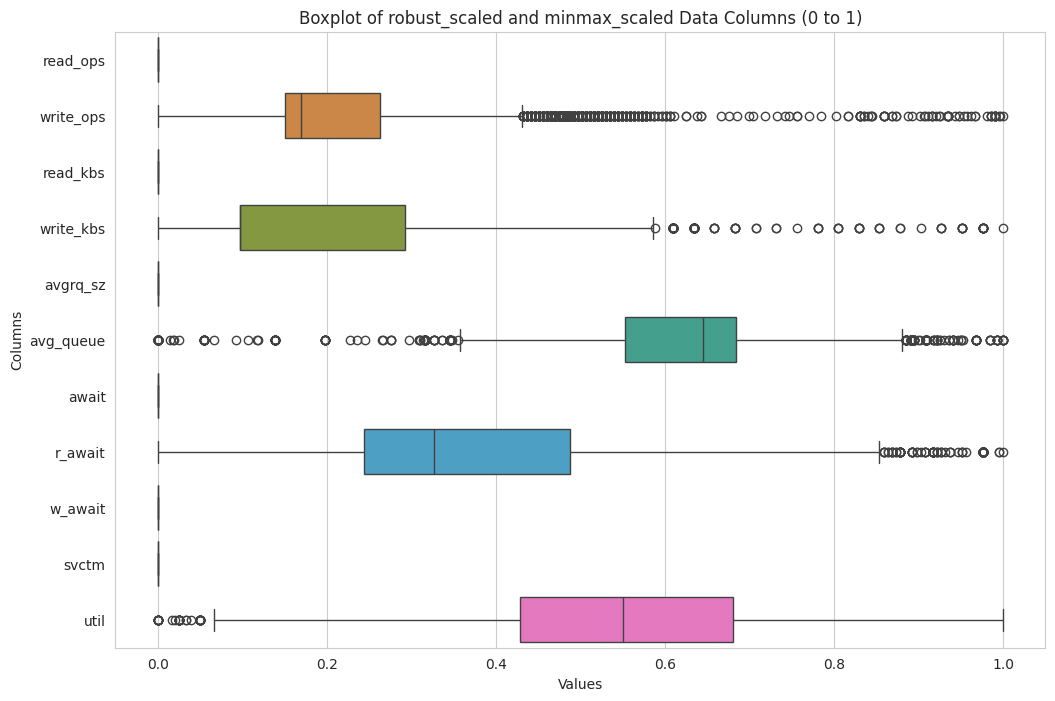

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Columns')
# plt.xticks(rotation=45)
plt.xlabel('Values')

plt.title('Boxplot of robust_scaled and minmax_scaled Data Columns (0 to 1)')
plt.show()

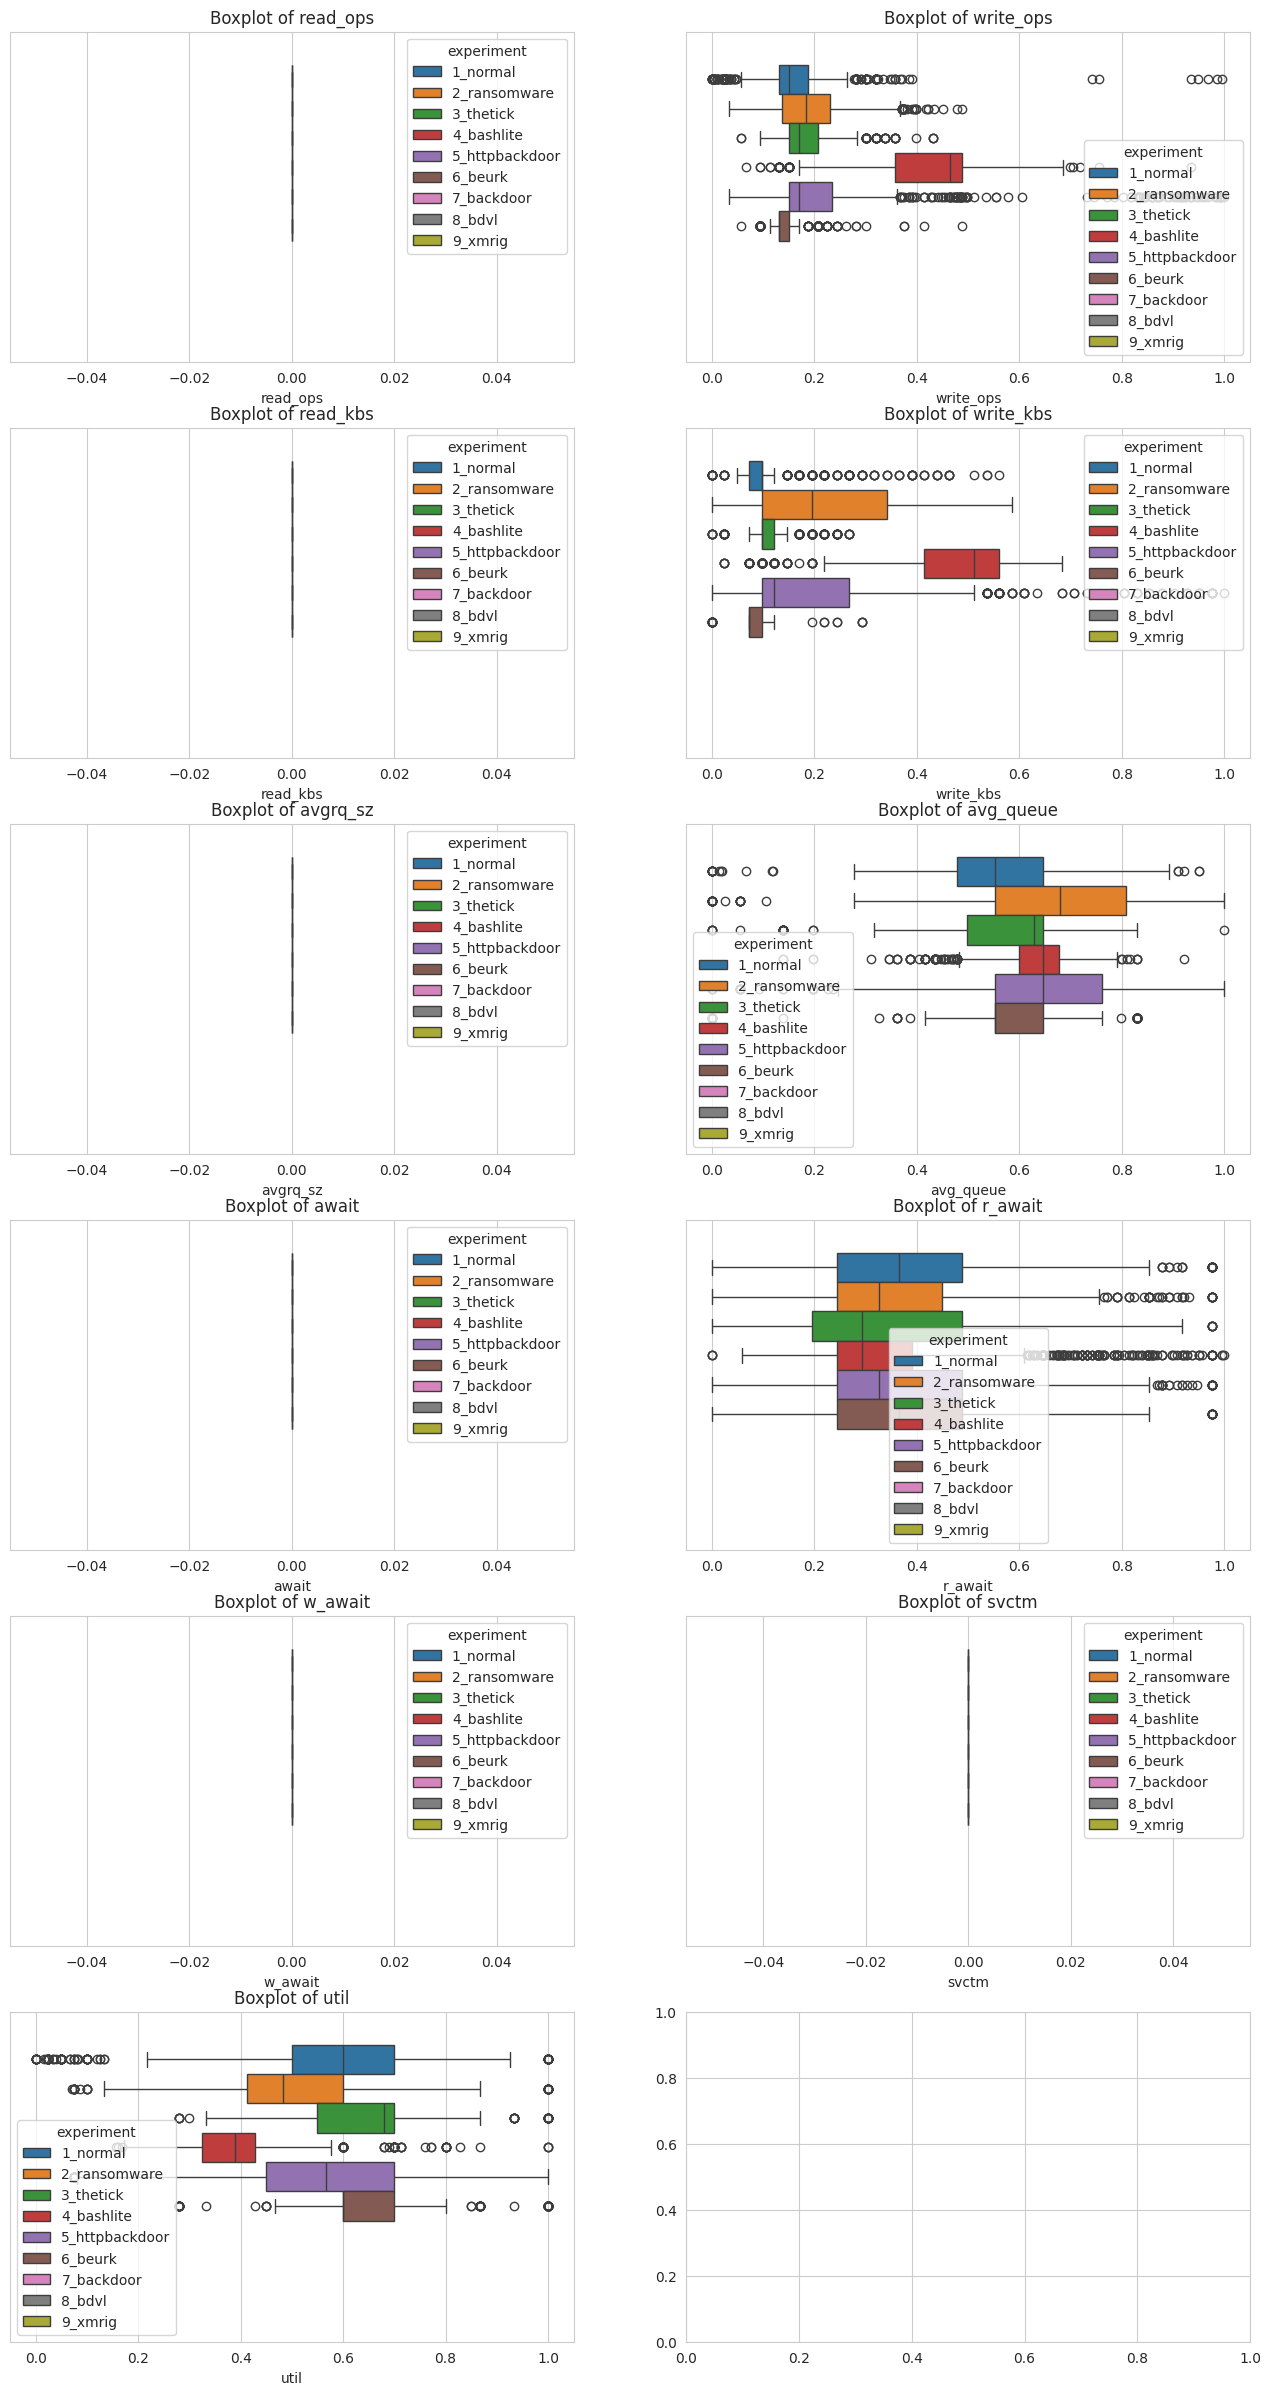

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

fig, axs = plt.subplots(6, 2, figsize=(16, 30))

# Flatten the axes for easier indexing
axs = axs.flatten()

# labels = vectors_scaled["experiment"].unique()
# handles, labels = axs[0].get_legend_handles_labels()

# Plot each column as a boxplot
for i, column in enumerate(vectors_scaled.columns):
    if column == "experiment":
        continue

    sns.boxplot(data=vectors_scaled, x=column, ax=axs[i], hue="experiment", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'Boxplot of {column}')
    # axs[i].set_xlabel('Values')

# axs[1].legend(['Survived', 'Not Survived'])

# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.xlabel('Values')
# plt.legend(loc='upper right')
# plt.tight_layout()
# labels = vectors_scaled["experiment"].unique()
# # handles, labels = axs[0].get_legend_handles_labels()
# plt.legend(labels, loc='upper right')
plt.show()

#### Make a narrow dataset

In [117]:
vectors_scaled.head(1)

,read_ops,write_ops,read_kbs,write_kbs,avgrq_sz,avg_queue,await,r_await,w_await,svctm,util,experiment
0,0.0,0.131455,0.0,0.073171,0.0,0.553195,0.0,0.243902,0.0,0.0,0.6,1_normal


In [118]:
narrow_df = pd.melt(vectors_scaled, id_vars=['experiment'], var_name='x', value_name='y')
narrow_df.head(1)

,experiment,x,y
0,1_normal,read_ops,0.0


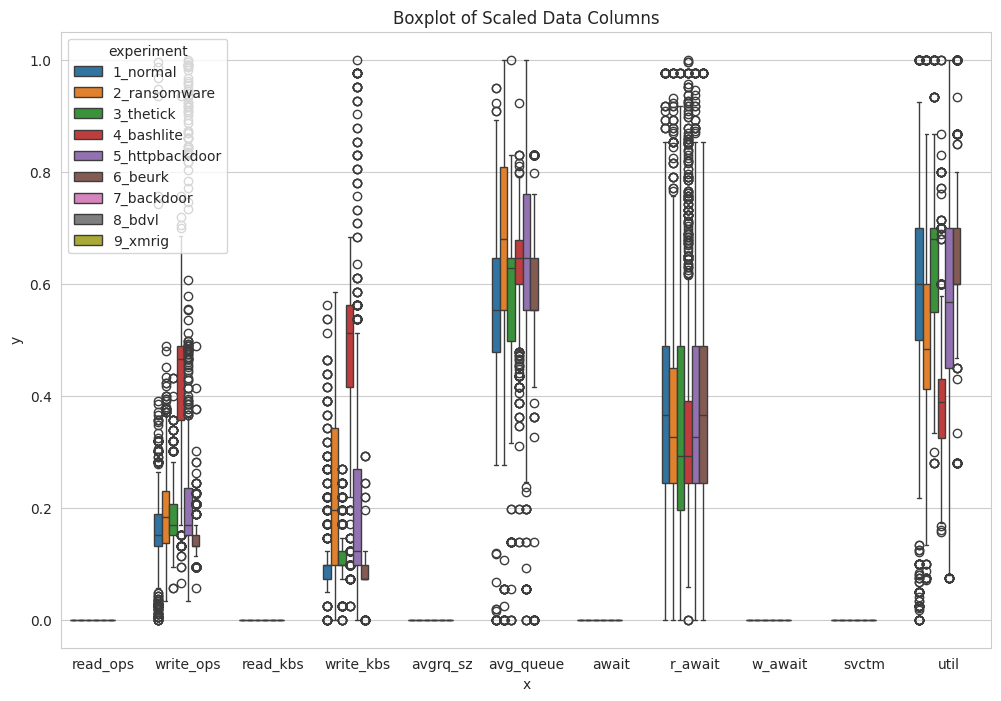

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=narrow_df, x="x", y="y",  #orient="h",
            hue="experiment")  # x="class", y="age", legend="full", native_scale=True,

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

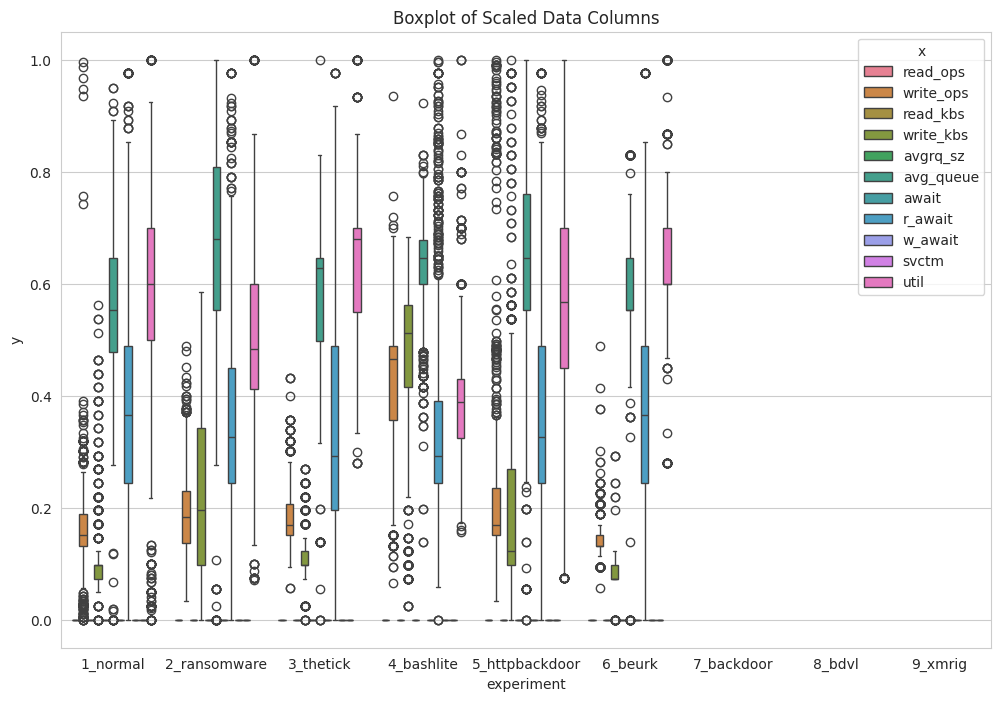

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.boxplot(data=narrow_df, x="experiment", y="y",  #orient="h",
            hue="x")  # x="class", y="age", legend="full", native_scale=True,

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()